In [24]:
import numpy as np
import pandas as pd
import os
import rasterio
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# choose oparating system

syst_op = 'mac'

if syst_op == 'mac':
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')
elif syst_op == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')

In [2]:
# open the .tif file

with rasterio.open("pre_processing/maps/wind_maps/max_all_storms.tif") as src:
    # Read the entire image
    image_array = src.read()

# Read the .tfw file
with open("pre_processing/maps/wind_maps/max_all_storms.tfw") as f:
    tfw_data = [float(line.strip()) for line in f.readlines()]

# Unpack the transformation parameters
pixel_size_x, rotation_y, rotation_x, pixel_size_y, x_origin, y_origin = tfw_data

# remove the first dimension

wind_array = np.squeeze(image_array)

In [3]:
# Define the dimensions of your wind speed array
rows, cols = wind_array.shape

# Generate the latitude and longitude arrays
latitudes = y_origin + np.arange(rows) * pixel_size_y
longitudes = x_origin + np.arange(cols) * pixel_size_x

# Create mesh grids for latitude and longitude
lat_grid, lon_grid = np.meshgrid(latitudes, longitudes, indexing='ij')

In [ ]:
# Flatten grids and wind_speed array
lat_flat = lat_grid.flatten()
lon_flat = lon_grid.flatten()
wind_flat = wind_array.flatten()

# Combine into a single array
result = np.column_stack((lat_flat, lon_flat, wind_flat))
df = pd.DataFrame(result, columns=['Latitude', 'Longitude', 'Wind Speed'])

# save the dataframe as a .csv file
df.to_csv('pre_processing/cluster/max_all_storms.csv', index=False)

# Show first few rows
print(df.head())

   Latitude  Longitude     Wind Speed
0      71.0     -12.00  1.790000e+308
1      71.0     -11.75  1.790000e+308
2      71.0     -11.50  1.790000e+308
3      71.0     -11.25  1.790000e+308
4      71.0     -11.00  1.790000e+308


/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count


In [12]:
# now create clusters using the k-means algorithm

data = wind_flat.reshape(-1, 1)
data = data[data < 1e7]
data = data.reshape(-1, 1)

# Create the KMeans object
kmeans = KMeans(n_clusters=6)

# Fit the KMeans object to the data
kmeans.fit(data)

print(kmeans.cluster_centers_)

# see the limits of each cluster
print(kmeans.labels_)
print(kmeans.labels_.shape)



[[23.15420976]
 [34.87082022]
 [30.41372757]
 [41.36096633]
 [20.03631534]
 [26.46476463]]
[1 1 1 ... 4 4 4]
(17366,)


In [19]:
# try with a pca first by converting the coordinates and standardizing the wind speed

# remove rows with very large values (not actual wind speeds)
df_filtered = df[df['Wind Speed'] < 1e7]

# convert the longitude and latitude to UTM coordinates

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered)

#df_filtered['Latitude'] = np.radians(df_filtered['Latitude'])
#df_filtered['Longitude'] = np.radians(df_filtered['Longitude'])


'''df_filtered['x'] = np.cos(df_filtered['Latitude']) * np.cos(df_filtered['Longitude'])
df_filtered['y'] = np.cos(df_filtered['Latitude']) * np.sin(df_filtered['Longitude'])'''
#df_filtered['z'] = np.sin(df_filtered['Latitude'])

# standardize the wind speed

#df_filtered['Wind Speed'] = (df_filtered['Wind Speed'] - df_filtered['Wind Speed'].mean()) / df_filtered['Wind Speed'].std()

# drop the latitude and longitude columns

#df_filtered = df_filtered.drop(['Latitude', 'Longitude'], axis=1)

# transpose the dataframe

#df_filtered = df_filtered.T

# save the dataframe as a .csv file
df_filtered.to_csv('pre_processing/cluster/max_all_storms_pca.csv', index=False)


In [30]:
# Définition du nombre de clusters
k = 7  # Vous pouvez choisir un autre nombre en fonction de vos données

# Application de K-means
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(X_scaled)

# Ajout des étiquettes de clusters au jeu de données
df_filtered['cluster_kmeans'] = kmeans.labels_

# Définition des paramètres
eps = 0.83  # Rayon maximal pour considérer un point comme voisin
min_samples = 15  # Nombre minimal de points pour former un cluster

# Application de DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(X_scaled)

# Ajout des étiquettes de clusters au jeu de données
df_filtered['cluster_dbscan'] = dbscan.labels_

/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_16076/2845438313.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cluster_kmeans'] = kmeans.labels_
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_16076/2845438313.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cluster_dbscan'] = dbscan.labels_


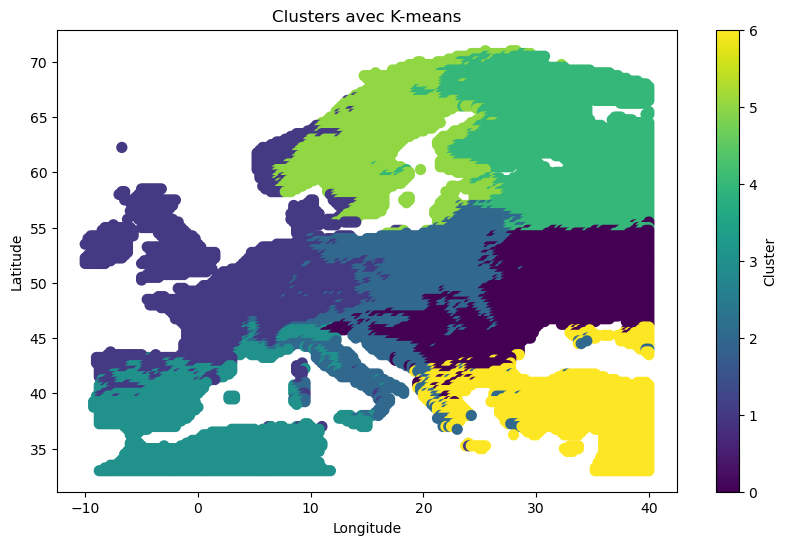

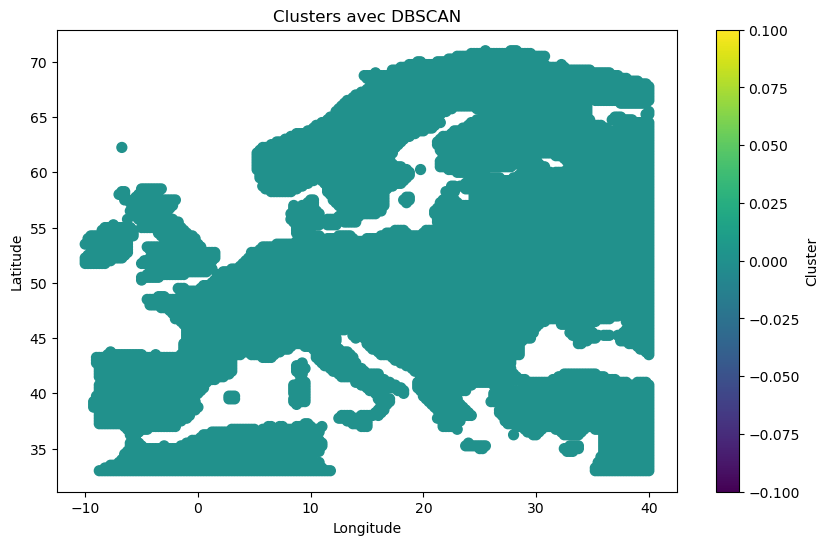

In [31]:
def plot_clusters(data, cluster_label, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(
        data['Longitude'],
        data['Latitude'],
        c=data[cluster_label],
        cmap='viridis',
        s=50
    )
    plt.colorbar(label='Cluster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.show()

# Visualisation des clusters K-means
plot_clusters(df_filtered, 'cluster_kmeans', 'Clusters avec K-means')

# Visualisation des clusters DBSCAN
plot_clusters(df_filtered, 'cluster_dbscan', 'Clusters avec DBSCAN')

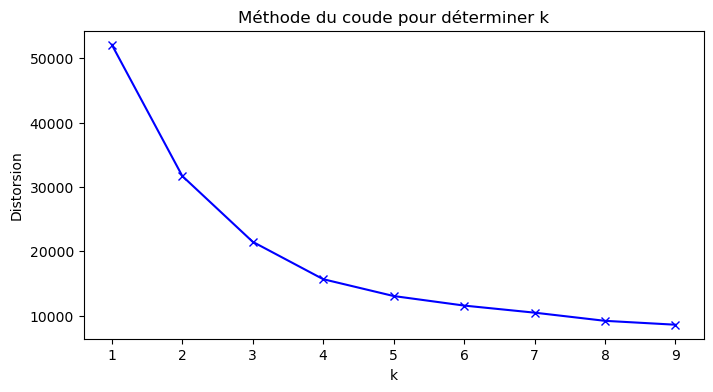

In [27]:
# Méthode du coude pour trouver le nombre optimal de clusters
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distorsion')
plt.title('Méthode du coude pour déterminer k')
plt.show()

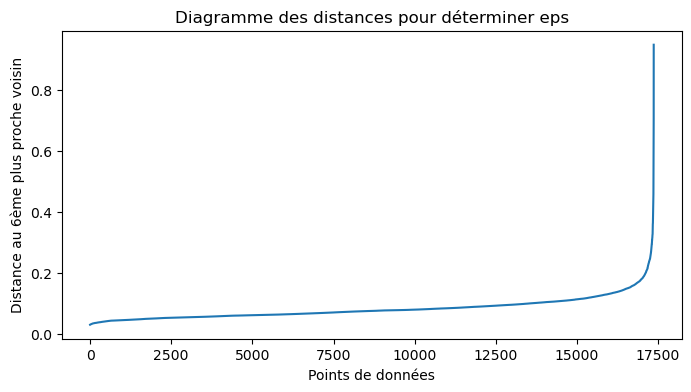

In [29]:
from sklearn.neighbors import NearestNeighbors

# Calcul des distances aux k plus proches voisins
k = 6  # k est généralement égal à min_samples
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

# Tri des distances pour trouver un point d'inflexion
distances = np.sort(distances[:, k-1], axis=0)

# Visualisation du diagramme des distances
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.xlabel('Points de données')
plt.ylabel(f'Distance au {k}ème plus proche voisin')
plt.title('Diagramme des distances pour déterminer eps')
plt.show()

In [31]:
# apply the pca

pca = PCA(n_components=3)
pca.fit(df_filtered)
pca_data = pca.transform(df_filtered)

[8.5346783e-01 1.4653217e-01 6.6739224e-30]


KeyError: 'Wind Speed'

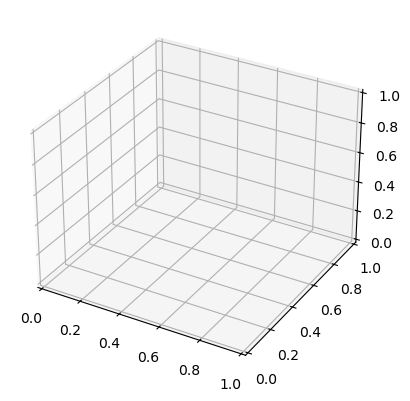

In [32]:
# see how much variance is explained by the first 3 components

print(pca.explained_variance_ratio_)

# plot the first two components

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[:, 0], pca_data[:, 1], c=df_filtered['Wind Speed'])
plt.show()

In [ ]:
# try with DBSCAN

'''for i in range(1,1000): 
e = i/100 #keeping eps = 1.63, 0.83, 0.65
(print(e))'''
e=0.65

db = DBSCAN(eps=e, min_samples=15).fit(df_filtered)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 40
Estimated number of noise points: 1675


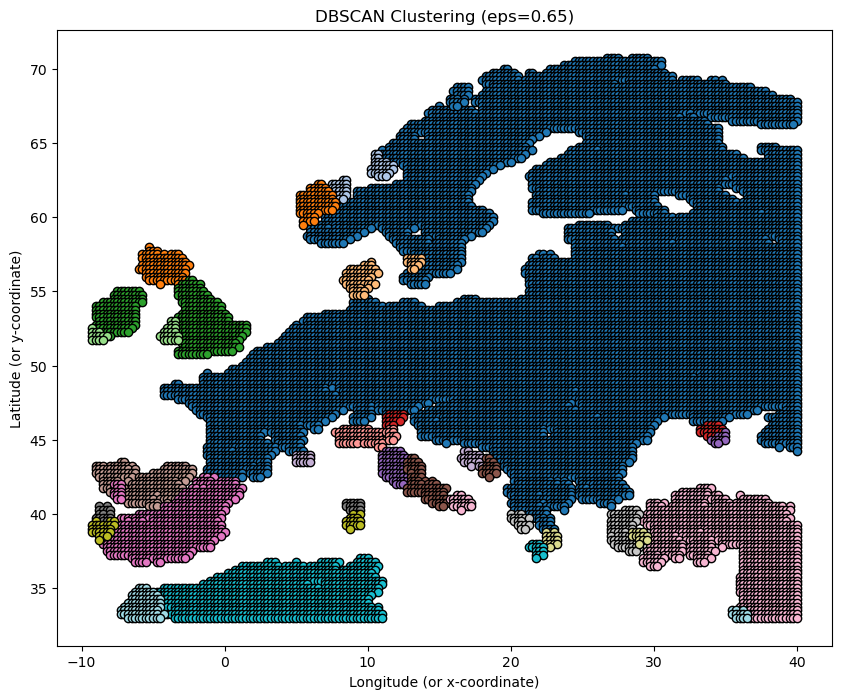

In [85]:
import matplotlib.pyplot as plt

# Extract coordinates and cluster labels
x = df_filtered['Longitude']  # Replace 'x' with your longitude (or projected x)
y = df_filtered['Latitude']  # Replace 'y' with your latitude (or projected y)

# Scatter plot
plt.figure(figsize=(10, 8))
unique_labels = set(labels)
colors = plt.cm.tab20(np.linspace(0, 1, n_clusters_))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black color for noise
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    plt.plot(
        x[class_member_mask],
        y[class_member_mask],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=6,
    )

plt.title("DBSCAN Clustering (eps={})".format(e))
plt.xlabel("Longitude (or x-coordinate)")
plt.ylabel("Latitude (or y-coordinate)")
plt.show()